In [1]:
import pandas as pd
#обучениет
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import VotingClassifier

from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_columns', 110)
pd.set_option('display.max_colwidth', None)
import joblib


In [2]:
df = pd.read_feather('../predaid/final.feather')

In [3]:
df['original_order_id'].fillna(df['id'], inplace=True)

is_group_paid = df.groupby('original_order_id')['status_id'].transform(lambda x: x.isin([6, 13, 15, 5]).any()).astype(int)

df['target'] = is_group_paid


In [6]:



# Процент заявок, где не было доступных учителей, относительно всех заявок клиента
#df['no_teacher_available_rate'] = df.groupby('client_id')['no_teachers_available'].transform('mean')

# Популярность предмета: общее количество заявок по предмету
df['subject_popularity'] = df.groupby('subject_id')['id'].transform('count')

# Сезонные колебания спроса на предметы
df['subject_order_monthly'] = df.groupby(['subject_id', df['order_date'].dt.month])['id'].transform('count')



In [7]:
# Заполняем нулями
df['subject_id'].fillna(0, inplace=True)
df['home_metro_id'].fillna(0, inplace=True)
df['creator_id'].fillna(0, inplace=True)
df['pupil_category_new_id'].fillna(0, inplace=True)

In [8]:
# Заполняем нулями
df['num_sessions_weekly'].fillna(0, inplace=True)

# Заполняем медианными значениями
df['tutor_experience_years'].fillna(df['tutor_experience_years'].median(), inplace=True)
df['tutor_age_from'].fillna(df['tutor_age_from'].median(), inplace=True)

In [9]:
# Заполняем средними значениями
group_features = [
    'group_avg_lesson_price',
    'group_avg_lesson_duration',
    'unique_clients_in_group',
    'group_min_lesson_price',
    'group_max_lesson_price',
    'group_avg_lessons_per_week',
    'date_diff_within_group'
]
for feature in group_features:
    df[feature].fillna(df[feature].mean(), inplace=True)

In [10]:
#Заполняем средней стоимостью урока
df['avg_lesson_cost'] = df.apply(
    lambda row: row['lesson_price'] / row['lesson_duration'] if row['lesson_duration'] > 0 else df.loc[df['lesson_duration'] > 0, 'lesson_price'].mean() / df.loc[df['lesson_duration'] > 0, 'lesson_duration'].mean(),
    axis=1
)

In [11]:
# Заполняем нулями
df['price_deviation_from_group_avg'].fillna(0, inplace=True)
df['percent_of_60min_lessons_in_group'].fillna(0, inplace=True)

In [12]:
df['subject_popularity'].fillna(df['subject_popularity'].median(), inplace=True)
df['subject_order_monthly'].fillna(0, inplace=True)

In [13]:
label_encoder = LabelEncoder()
# Применяем LabelEncoder к колонке 'student_category'
df['student_category_encoded'] = label_encoder.fit_transform(df['student_category'])

# Удаляем исходную колонку 'student_category'
df.drop('student_category', axis=1, inplace=True)

In [14]:
df.fillna(0,inplace=True)

In [15]:
df = df.dropna(subset=['order_id','user_id','order_date','amount_to_pay_x','amount_to_pay_y','purpose','add_info'])

# Сброс индексов после удаления строк
df.reset_index(drop=True, inplace=True)

In [16]:
duplicates = {}

# Перебор всех колонок для сравнения
for i, col1 in enumerate(df.columns):
    for col2 in df.columns[i + 1:]:
        # Проверка на идентичность данных в колонках
        if df[col1].equals(df[col2]):
            # Запись найденных дубликатов
            duplicates.setdefault(col1, []).append(col2)

# Вывод результатов
if duplicates:
    for key, values in duplicates.items():
        print(f"Колонка '{key}' дублируется в колонках: {values}")
else:
    print("Дублирующихся колонок не найдено.")

Дублирующихся колонок не найдено.


In [17]:
df = df.drop(columns=['amount_to_pay_x','amount_to_pay_y','purpose','add_info'])

In [18]:
# Получение уникальных идентификаторов заказов
unique_order_ids = df['original_order_id'].unique()

# Разделение идентификаторов заказов на обучающую и тестовую выборки
train_order_ids, test_order_ids = train_test_split(unique_order_ids, test_size=0.3, random_state=777)

# Создание столбца для идентификации принадлежности к выборке
df['is_train'] = df['original_order_id'].isin(train_order_ids).astype(int)

In [19]:
is_group_paid_train = df[df['is_train'] == 1].groupby('original_order_id')['status_id'].transform(lambda x: x.isin([6, 13, 15, 5]).any()).astype(int)
is_group_paid_test = df[df['is_train'] == 0].groupby('original_order_id')['status_id'].transform(lambda x: x.isin([6, 13, 15, 5]).any()).astype(int)


In [20]:

# Создание столбца целевой переменной в исходном DataFrame
df.loc[df['is_train'] == 1, 'target'] = is_group_paid_train
df.loc[df['is_train'] == 0, 'target'] = is_group_paid_test

# Подготовка данных для CatBoost.
train_data = df[df['is_train'] == 1].drop(columns=['target', 'is_train','status_id','order_date','client_id'])
test_data = df[df['is_train'] == 0].drop(columns=['target', 'is_train','status_id','order_date','client_id'])
train_labels = df[df['is_train'] == 1]['target']
test_labels = df[df['is_train'] == 0]['target']

In [21]:
# Параметры для GridSearchCV
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [300],
}

# Инициализация модели CatBoostClassifier 
catboost_model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=777,
    verbose=50,
    task_type="CPU",
    thread_count=-1
)
grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(train_data, train_labels)

# Лучшие параметры и модель
print("Лучшие параметры:", grid_search.best_params_)
best_catboost_model = grid_search.best_estimator_


0:	total: 510ms	remaining: 2m 32s
50:	total: 15.6s	remaining: 1m 16s
100:	total: 31.1s	remaining: 1m 1s
150:	total: 44.9s	remaining: 44.3s
200:	total: 1m	remaining: 29.8s
250:	total: 1m 11s	remaining: 14s
299:	total: 1m 22s	remaining: 0us
Лучшие параметры: {'depth': 8, 'iterations': 300, 'learning_rate': 0.01}


In [22]:
best_catboost_model.save_model('catboost_model(prod_v2).cbm')

no_teachers_available: 15.995987663115889
client_orders_count: 12.295772772612048
rating_for_admin: 10.131248727812022
planned_lesson_number: 7.171117684289946
unique_clients_in_group: 5.023609208331822
percent_of_60min_lessons_in_group: 3.7799755078822685
price_deviation_from_group_avg: 3.1033474804085466
pupil_category_new_id: 3.041618242162592
enable_assign: 2.970525749804733
source_id: 2.8073386344756903
original_order_id: 2.3352430956207892
date_diff_within_group: 2.3264538612682646
rating_for_users: 2.3181135301684264
rating_for_users_yesterday: 2.237361226358047
id: 2.2118491534747933
review_num: 2.0299759471227397
lesson_place_new: 1.991789572481428
home_metro_id: 1.968717109187917
order_year: 1.4813015098504643
order_id: 1.472253356543172
star_rating: 1.038543530537489
home_country_id.2: 0.859364299942732
subject_id: 0.8002701510087115
lesson_price: 0.7591322833362435
group_max_lesson_price: 0.7392187810459117
is_display_to_teachers: 0.7369760793707856
years_since_reg: 0.68214

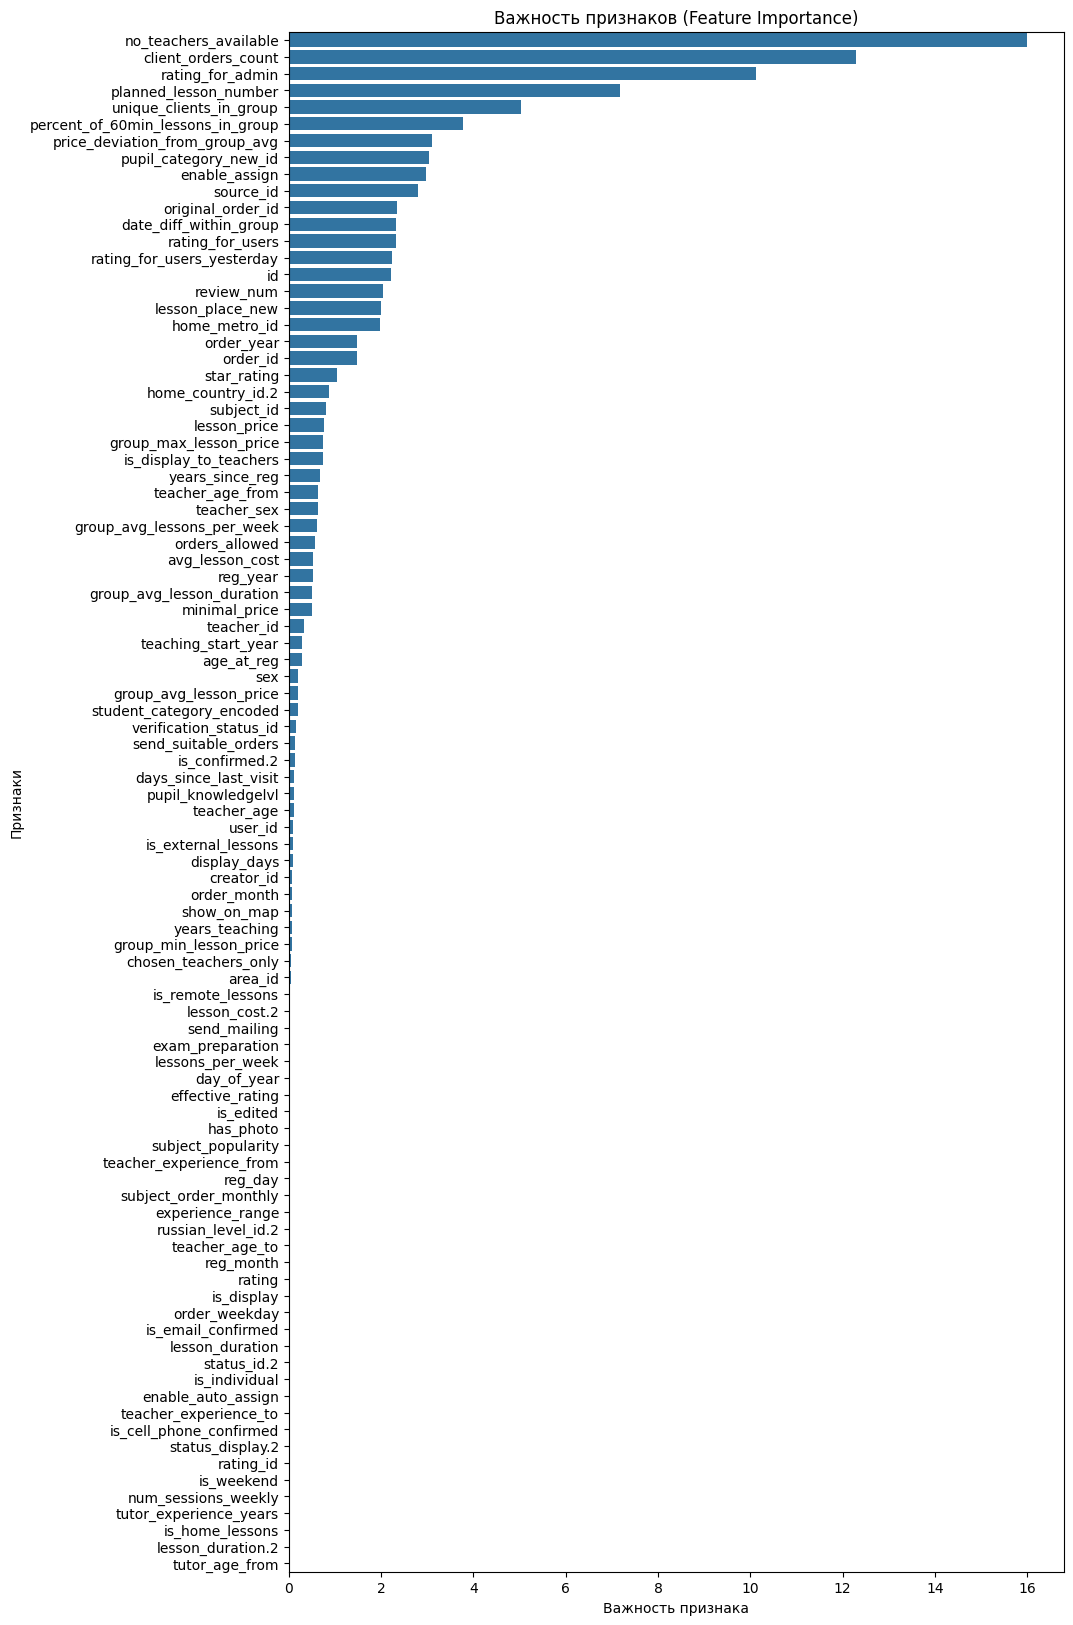

In [23]:
feature_importances = best_catboost_model.get_feature_importance()

# Выводим важность каждого признака
feature_names = train_data.columns
# Сортировка важности признаков и их названий для визуализации
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

for name, importance in zip(sorted_feature_names, sorted_feature_importances):
    print(f"{name}: {importance}")

# Создание графика
plt.figure(figsize=(10,20))
sns.barplot(x=sorted_feature_importances, y=sorted_feature_names)
plt.title('Важность признаков (Feature Importance)')
plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.show()


In [24]:

# Сетка гиперпараметров для LightGBM
param_grid_lgb = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [300],
    'num_leaves': [20, 31, 40]
}

# Инициализация модели LightGBM
lgb_model = LGBMClassifier(
    objective='binary',
    metric='auc',
    random_state=777,
    n_jobs=-1
)

# Подбор гиперпараметров
grid_search_lgb = GridSearchCV(estimator=lgb_model, param_grid=param_grid_lgb, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search_lgb.fit(train_data, train_labels)

# Лучшие параметры и модель
print(grid_search_lgb.best_params_)
best_lgb_model = grid_search_lgb.best_estimator_


[LightGBM] [Info] Number of positive: 198234, number of negative: 628535
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9043
[LightGBM] [Info] Number of data points in the train set: 826769, number of used features: 92
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239770 -> initscore=-1.153944
[LightGBM] [Info] Start training from score -1.153944
{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300, 'num_leaves': 40}


In [25]:
joblib.dump(best_lgb_model, 'lightgbm_model(prod_v2).pkl')

['lightgbm_model(prod_v2).pkl']

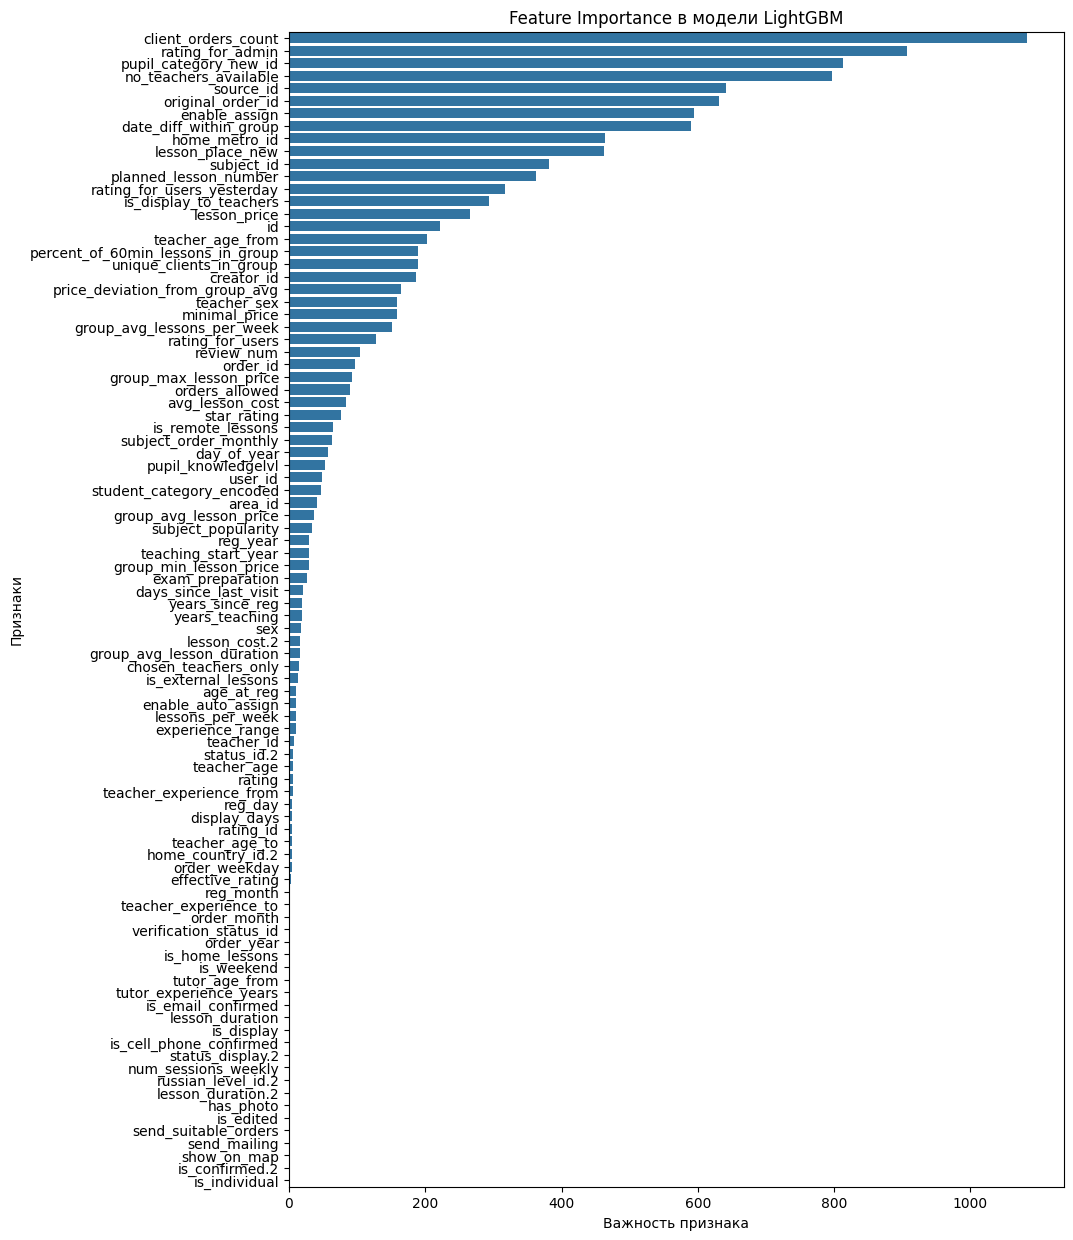

In [26]:

feature_importances = best_lgb_model.feature_importances_
feature_names = best_lgb_model.feature_name_

# Создаем DataFrame для удобства сортировки и визуализации
df_features = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Сортируем по важности
df_features_sorted = df_features.sort_values(by='Importance', ascending=False)

# Визуализация отсортированной важности признаков
plt.figure(figsize=(10, 15))
sns.barplot(x='Importance', y='Feature', data=df_features_sorted, orient='h')
plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.title('Feature Importance в модели LightGBM')
plt.show()

In [27]:
# Сетка гиперпараметров для XGBoost
param_grid_xgb = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [300],
}

# Инициализация модели XGBoost
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    random_state=777,
    verbosity=1,
    n_jobs=-1 
)

# Подбор гиперпараметров
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search_xgb.fit(train_data, train_labels)

# Лучшие параметры и модель
print(grid_search_xgb.best_params_)
best_xgb_model = grid_search_xgb.best_estimator_

{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300}


In [28]:
best_xgb_model.save_model('xgboost_model(prod_v2).json')

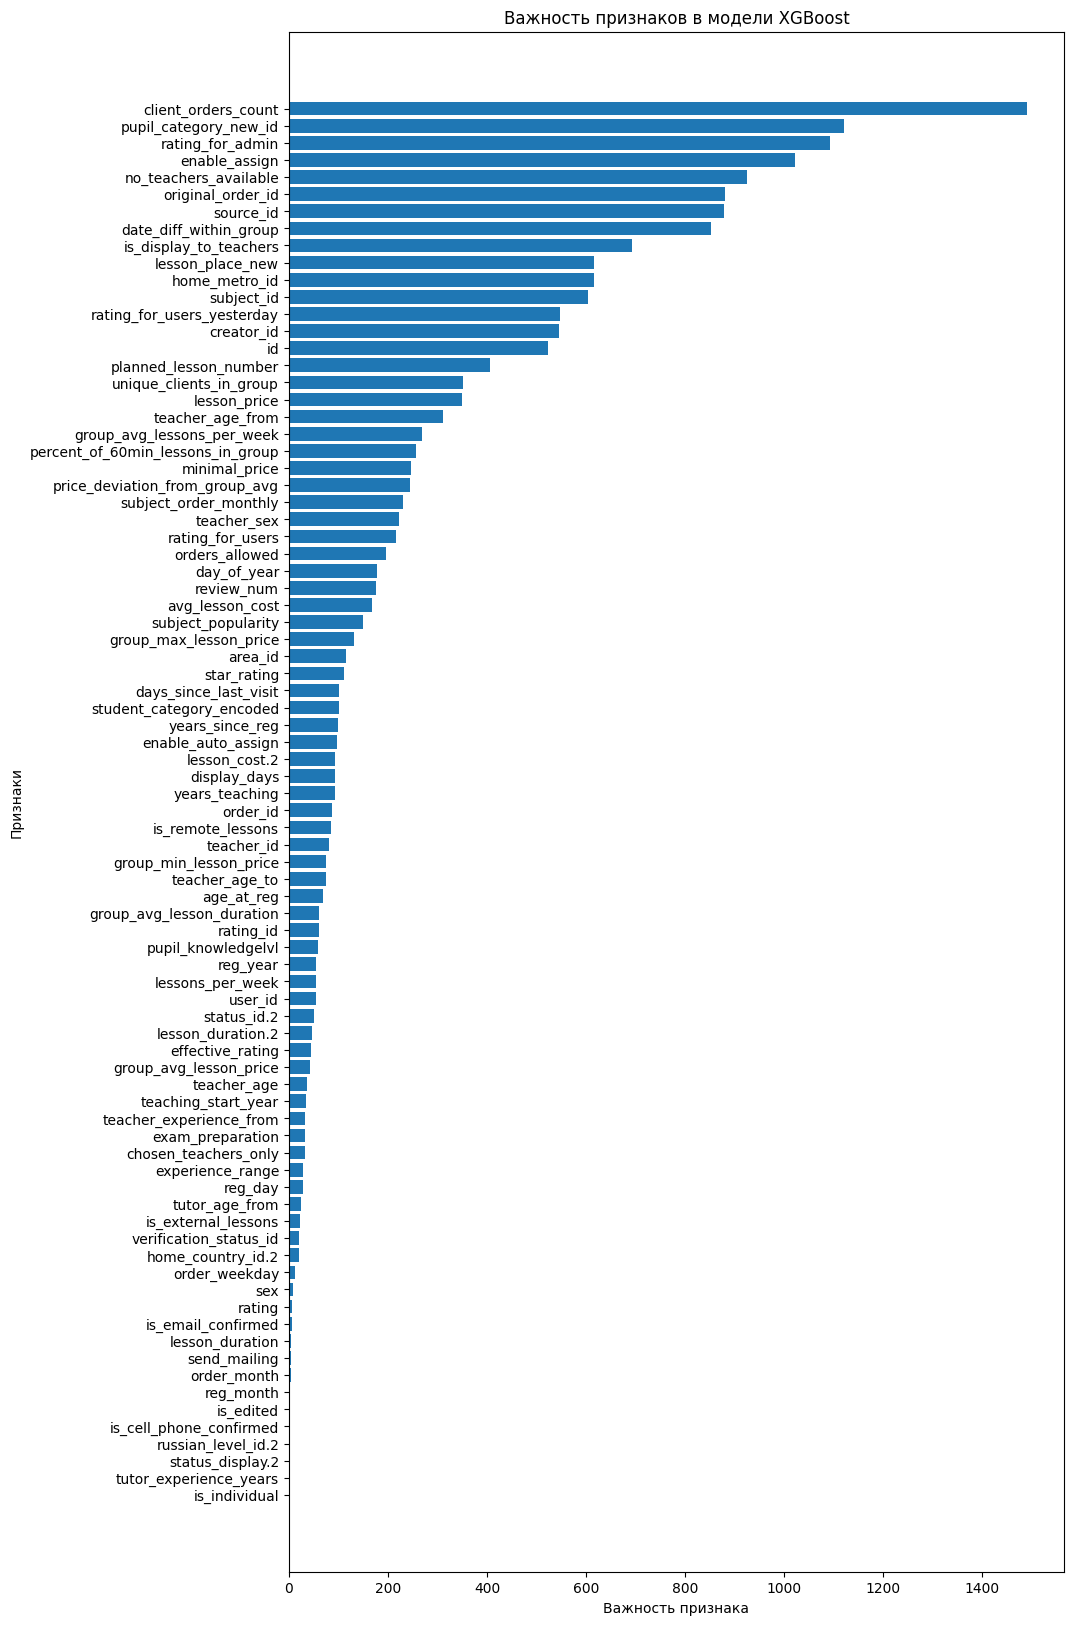

In [29]:
# Получаем важность признаков
booster = best_xgb_model.get_booster()
feature_importances = booster.get_score(importance_type='weight')

features, importances = zip(*feature_importances.items())

# Сортировка признаков по важности
sorted_indices = np.argsort(importances)[::-1]
sorted_features = [features[idx] for idx in sorted_indices]
sorted_importances = [importances[idx] for idx in sorted_indices]

# Визуализация важности признаков
plt.figure(figsize=(10, 20))
plt.title("Важность признаков в модели XGBoost")
plt.barh(range(len(sorted_features)), sorted_importances, align='center')
plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlabel("Важность признака")
plt.ylabel("Признаки")
plt.gca().invert_yaxis() 
plt.show()

In [30]:
# Загрузка модели CatBoost
catboost_model = CatBoostClassifier()
catboost_model.load_model('catboost_model(prod_v2).cbm')

# Загрузка модели LightGBM
lgb_model = joblib.load('lightgbm_model(prod_v2).pkl')

# Загрузка модели XGBoost
xgb_model = XGBClassifier()
xgb_model.load_model('xgboost_model(prod_v2).json')

In [31]:
preds_catboost = catboost_model.predict_proba(test_data)[:, 1]
preds_lgb = lgb_model.predict_proba(test_data)[:, 1]
preds_xgb = xgb_model.predict_proba(test_data)[:, 1]

# Создание матрицы признаков для мета-модели
X_meta = np.column_stack((preds_catboost, preds_lgb, preds_xgb))

In [32]:
# Разделяем на обучающую и валидационную выборки
X_meta_train, X_meta_valid, y_meta_train, y_meta_valid = train_test_split(
    X_meta, test_labels, test_size=0.3, random_state=777, stratify=test_labels)

# Обучаем Random Forest как мета-модель
rf_meta_model = RandomForestClassifier(n_estimators=200, random_state=777)
rf_meta_model.fit(X_meta_train, y_meta_train)

# Делаем предсказания на валидационной выборке
meta_preds = rf_meta_model.predict(X_meta_valid)
meta_probs = rf_meta_model.predict_proba(X_meta_valid)[:, 1]

# Вычисляем метрики
roc_auc = roc_auc_score(y_meta_valid, meta_probs)
precision, recall, f1_score, support = precision_recall_fscore_support(y_meta_valid, meta_preds)

# Выводим метрики
print(f"ROC-AUC: {roc_auc}")
print(f"Precision:\n0: {precision[0]}\n1: {precision[1]}")
print(f"Recall:\n0: {recall[0]}\n1: {recall[1]}")
print(f"F1-score:\n0: {f1_score[0]}\n1: {f1_score[1]}")
print(f"Support:\n0: {support[0]}\n1: {support[1]}")



ROC-AUC: 0.7636571018146486
Precision:
0: 0.8077894714210464
1: 0.5569039514577475
Recall:
0: 0.9261934402386264
1: 0.2962292371880658
F1-score:
0: 0.8629488843207735
1: 0.3867420349434738
Support:
0: 81131
1: 25406


In [43]:
# Сохранение обученной мета-модели
joblib.dump(rf_meta_model, 'rf_meta_modelv(prod).joblib')

['rf_meta_modelv(prod).joblib']

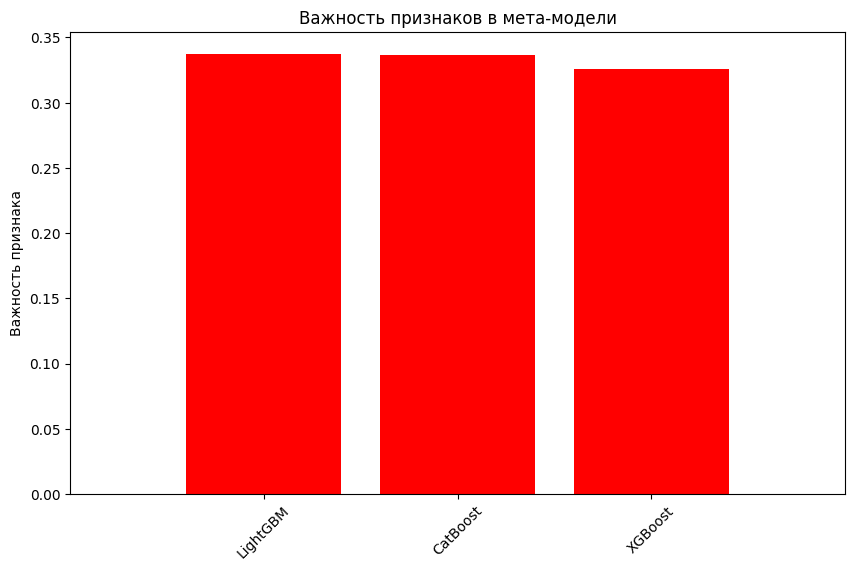

In [33]:
feature_importances = rf_meta_model.feature_importances_
feature_names = ['CatBoost', 'LightGBM', 'XGBoost']

# Сортировка признаков по важности
indices = np.argsort(feature_importances)[::-1]

# Создание графика
plt.figure(figsize=(10, 6))
plt.title("Важность признаков в мета-модели")
plt.bar(range(len(feature_importances)), feature_importances[indices], color="r", align="center")
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in indices], rotation=45)
plt.xlim([-1, len(feature_importances)])
plt.ylabel('Важность признака')
plt.show()

Разнообразие предсказаний - разные алгоритмы ансамблей Использование всех трех моделей в ансамбле позволяет объединить их уникальные преимущества.


Уменьшение переобучения -  Случайный лес как мета-модель может помочь уменьшить переобучение. Ведь при правильной настройке случайный лес способен обобщать данные, не склоняясь к чрезмерному запоминанию обучающего набора, благодаря случайности и разнообразию деревьев.


Улучшение точности предсказаний - Ансамбль с мета-моделью может дать лучшую обобщающую способность, чем любая из моделей по отдельности. Мета-модель обучается на предсказаниях базовых моделей, что позволяет ей выявлять и корректировать их систематические ошибки, что часто приводит к повышению точности предсказаний на неизвестных данных.

Гибкость - Такой подход позволяет гибко настраивать модели под конкретную задачу. Можно экспериментировать с разными типами мета-моделей и различными способами их обучения, чтобы найти наилучшее решение для конкретной задачи.

В общем, такой подход позволяет создать более мощную и устойчивую к ошибкам систему, что делает его очень